# REINFORCE

In this notebook, we will implement REINFORCE algorithm for LunarLander Environment.

## Lunar Lander

This environment is a classic rocket trajectory optimization problem. The landing pad is always at coordinates (0,0). The state is an 8-dimensional vector: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.

There are four discrete actions available:<br>
- 0: do nothing<br>
- 1: fire left orientation engine<br>
- 2: fire main engine<br>
- 3: fire right orientation engine<br>

After every step a reward is granted. The total reward of an episode is the sum of the rewards for all the steps within that episode.

For each step, the reward:

- is increased/decreased the closer/further the lander is to the landing pad.

- is increased/decreased the slower/faster the lander is moving.

- is decreased the more the lander is tilted (angle not horizontal).

- is increased by 10 points for each leg that is in contact with the ground.

- is decreased by 0.03 points each frame a side engine is firing.

- is decreased by 0.3 points each frame the main engine is firing.

The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.

An episode is considered a solution if it scores at least 200 points.


You can read more the LunarLander environment [here](https://gymnasium.farama.org/environments/box2d/lunar_lander/)

![LunarLander](https://gymnasium.farama.org/_images/lunar_lander.gif)

## Reinforce

REINFORCE is an elegant algorithm for maximizing the expected return. We sample a trajectory $\tau$ . If we get a high reward, we try to make it more likely. If we get a low reward, we try to make it less likely.

We just need a policy that maximizes the expected return and we can do this by Gradient Ascent on Policy parameters.

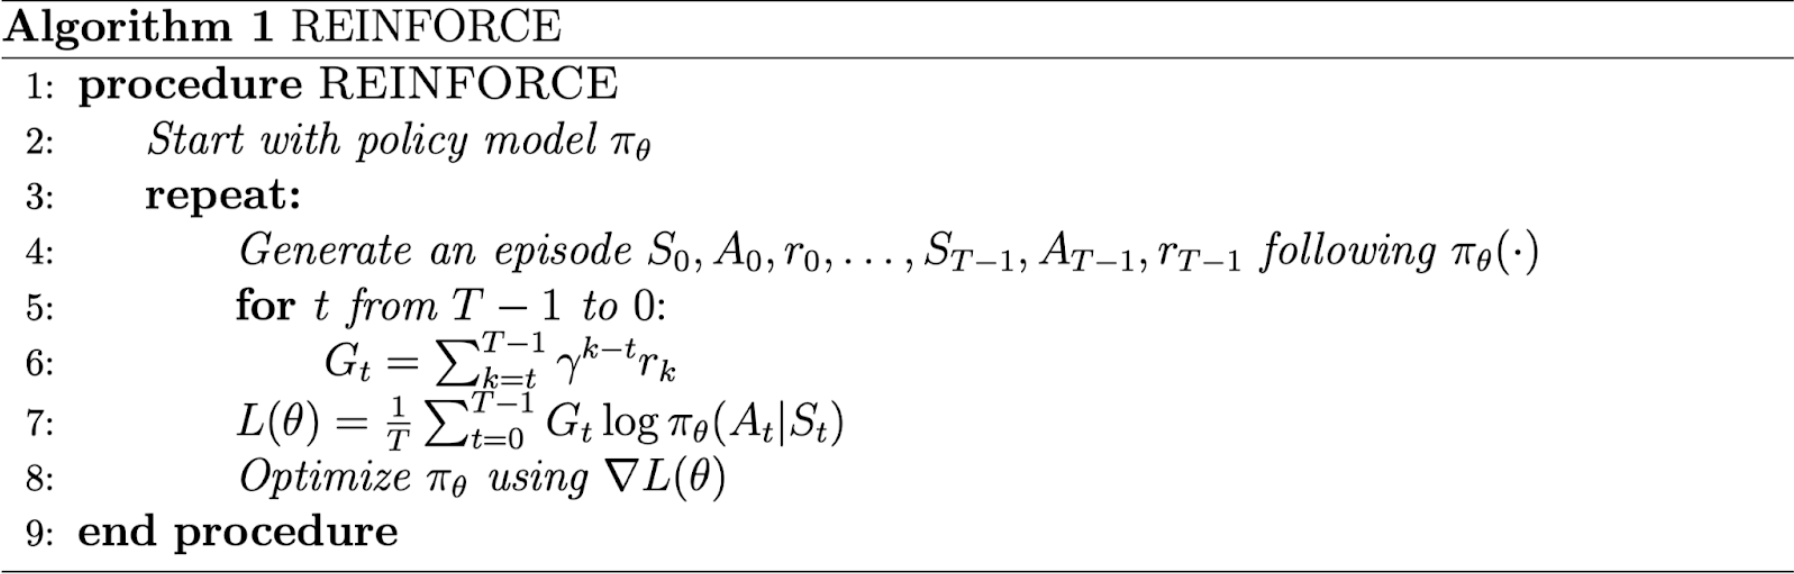


[Image Source](https://colab.research.google.com/github/huggingface/deep-rl-class/blob/master/notebooks/unit4/unit4.ipynb)

In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical

In [2]:
!pip install -q swig
!pip install -q gym[box2d]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 42.2 MB/s eta 0:00:00


In [8]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Create the environment
env = gym.make("LunarLander-v2")

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


### Policy Network

In [4]:
# A neural network for policy
class Policy(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(Policy, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        return F.softmax(x, dim=1)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)
# Code Here

### Hyperparameters

In [35]:
# Here, we will specify the hyperparameters
total_episodes = 3000
max_steps = 200
learning_rate = 0.005
gamma = 0.95

### Training

In [26]:
# Code Here
print('observation space:', env.observation_space)
print('action space:', env.action_space)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n

print('state size:', state_size)
print('action size:', action_size)

observation space: Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
action space: Discrete(4)
state size: 8
action size: 4


In [27]:
# Intialize policy network
policy_net = Policy(state_size, action_size).to(device)

# set up the optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

In [50]:
scores = []
for episode in range(1, total_episodes+1):
  saved_log_probs = []
  rewards = []
  state = env.reset()
  # collect trajectory
  for t in range(max_steps):
    # sample action and its log probability from policy
    action, log_prob = policy_net.act(state)
    # save the log probability for later use
    saved_log_probs.append(log_prob)
    state, reward, done, _ = env.step(action)
    rewards.append(reward)

    if done:
        break

  scores.append(sum(rewards))

  # Compute the discounted returns at each timestep
  returns = deque(maxlen=max_steps)
  n_steps = len(rewards)

  for t in range(n_steps)[::-1]:
    disc_return_t = (returns[0] if len(returns)>0 else 0)
    returns.appendleft( gamma*disc_return_t + rewards[t]   )

  eps = np.finfo(np.float32).eps.item()
  returns = torch.tensor(returns)
  returns = (returns - returns.mean()) / (returns.std() + eps)

  # Calculating policy loss:
  policy_loss = []
  for log_prob, disc_return in zip(saved_log_probs, returns):
    policy_loss.append(-log_prob * disc_return)
  policy_loss = torch.cat(policy_loss).sum()
  # Back propagation
  optimizer.zero_grad()
  policy_loss.backward()
  optimizer.step()

  print(f"Episode {episode}: Reward = {scores[-1]}")

Episode 1: Reward = 11.251115176796059
Episode 2: Reward = 49.57527139353206
Episode 3: Reward = 16.64288155618968
Episode 4: Reward = -9.362712652074524
Episode 5: Reward = 31.129401892989208
Episode 6: Reward = -5.161948460408402
Episode 7: Reward = 80.85783052167439
Episode 8: Reward = 8.233520126721027
Episode 9: Reward = 40.439987093947835
Episode 10: Reward = 34.80513710390964
Episode 11: Reward = 61.355192235554924
Episode 12: Reward = 66.75810262085332
Episode 13: Reward = 2.4981326478479167
Episode 14: Reward = 6.281407758525448
Episode 15: Reward = 20.021582672121916
Episode 16: Reward = 66.8126719693372
Episode 17: Reward = 2.486996947312303
Episode 18: Reward = 69.36810200698302
Episode 19: Reward = 9.30923256591271
Episode 20: Reward = 19.228441773861803
Episode 21: Reward = 12.114342136807242
Episode 22: Reward = -18.657223549674672
Episode 23: Reward = 25.558312923325868
Episode 24: Reward = 66.79329770989737
Episode 25: Reward = 40.41713918154136
Episode 26: Reward = 11

In [74]:
# Test the optimal policy
total_reward = 0
num_episodes = 100

for episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0

    for t in range(100):
        # Use the policy network to select an action
        with torch.no_grad():
            action, _ = policy_net.act(state)

        # Take the action in the environment
        next_state, reward, done, _ = env.step(int(action))

        # Update the state and the episode reward
        state = next_state
        episode_reward += reward

        if done:
            break

    total_reward += episode_reward

average_reward = total_reward / num_episodes
print(f"Average reward over {num_episodes} episodes: {average_reward:.2f}")

Average reward over 100 episodes: 19.05


### Visualization

In [76]:
# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import base64, io, os

os.environ['SDL_VIDEODRIVER']='dummy'

Text(0, 0.5, 'Reward')

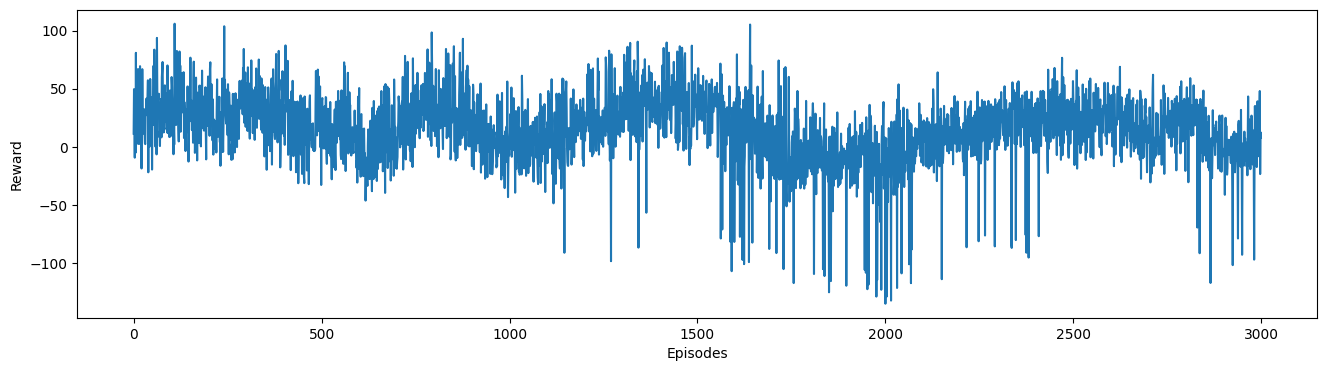

In [78]:
plt.figure(figsize=(16,4))
plt.plot(scores)
plt.xlabel("Episodes")
plt.ylabel("Reward")

In [79]:
os.makedirs("video", exist_ok=True)

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(env_name):
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state = env.reset()
    done = False
    for t in range(max_steps):
        vid.capture_frame()
        action, _ = policy_net.act(state) # code here
        next_state, reward, done, info = env.step(action)
        # print(f"state: {state}, action: {action.item()}",next_state, reward, done)
        state = next_state
        if done:
            break
    vid.close()
    env.close()

In [80]:
show_video_of_model("LunarLander-v2")

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


In [81]:
show_video("LunarLander-v2")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
